# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1L2UusxSvm9l9mYqcVdoMgETypN_OUkCn?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

In [1]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:14tcmalloc: large alloc 1147494400 bytes == 0x38fbc000 @  0x7f7449046615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:35tcmalloc: large alloc 1434370048 bytes == 0x7d612000 @  0x7f7449046615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
gotSpam = False
gotHam = False
for line in open('SMSSpamCollection'):
    if not gotHam and line.startswith("ham"):
      print("Non-spam example: ", line)
      gotHam = True
    if not gotSpam and line.startswith("spam"):
      print("Spam example: ", line)
      gotSpam = True
    if gotSpam and gotHam:
      break

Non-spam example:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam example:  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



Spam label is "spam" and non-spam label is "ham"

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [15]:
lines = list(open('SMSSpamCollection'))

spams = list(filter(lambda line: line.startswith("spam"), lines))
print("There are", len(spams), "spam messages")

There are 747 spam messages


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:

We only have 97 English characters while there are thousands of words =>

*   Our discrete space is smaller
*   We require less memory

Disadvantages



*   Input to the model would be larger since there are more characters in a message than words. So we will also need more hidden layers and more parameters
*   The model would have to learn spelling in addition to syntax, semantics



### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [5]:
text_field = torchtext.legacy.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True)

# the label field won't be sequential and we don't have to track the vocabulary
label_field = torchtext.legacy.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", "tsv", fields)

# split dataset into train, validation, and test set with ratio %60, %20, %20
train_set, val_set, test_set = dataset.split(split_ratio=[0.6, 0.2, 0.2])

In [21]:
print("There are", len(train_set), "samples in the training set.")
print("There are", len(val_set), "samples in the validation set.")
print("There are", len(test_set), "samples in the testing set.")

There are 3343 samples in the training set.
There are 1115 samples in the validation set.
There are 1114 samples in the testing set.


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [6]:
# save the original training examples
old_train_examples = train_set.examples
# get all the spam messages in `train`
train_spam = []
for item in train_set.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_set.examples = old_train_examples + train_spam * 6

If out training set is unbalance and we have many more non-spam messages, the model would be more likely to guess non-spam than spam and it would be biased. The model could even get a high training accuracy by guessing non-spam every time. So to get high testing accuracy we need the model to have learned both spam and ham messages.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [7]:
text_field.build_vocab(train_set)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fab7c30eb50>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, 'k': 28, '8': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'O': 34, 'C': 35, '4': 36, 'I': 37, 'N': 38, 'A': 39, 'x': 40, '3': 41, '7': 42, '6': 43, 'R': 44, ',': 45, '!': 46, 'P': 47, '9': 48, 'W': 49, 'M': 50, 'U': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'F': 56, 'Y': 57, 'G': 58, "'": 59, '?': 60, '/': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, ')': 71, 'J': 72, ';': 73, '*': 74, '+': 75, '(': 76, '"': 77, 'q': 78, 'Q': 79, '#': 80, '@': 81, '>': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '|': 87, '\x92': 88, '‘': 89, '<': 90, '_': 91, '$': 92, '%': 93, '…': 94, '[': 95, ']': 96, '\x93': 97, '\x94': 

`text_field.voab.stoi` is a dictionary mapping characters to numbers
`text_field.voab.stoi` is an array of the characters indexed by their numerical identifiers

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents unknown characters and `<pad>` is the padding that happens to unify all sms lengths in a batch

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [8]:
train_iter = torchtext.legacy.data.BucketIterator(train_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [70]:
batch_count = 1
max_batch_lens = []
batch_padding = []
for batch in train_iter:
    if batch_count == 11:
      break
    max_batch_lens.append(int(batch.sms[1][0]))
    pad = 0
    for sms in batch.sms[1]:
        pad += batch.sms[1][0] - sms
    batch_padding.append(int(pad))
    batch_count+=1

print("Max Length of the input sequence in each batch is:", max_batch_lens)
print("Number of padding tokens in each batch is:", batch_padding)

Max Length of the input sequence in each batch is: [115, 156, 37, 61, 146, 46, 140, 162, 153, 151]
Number of padding tokens in each batch is: [23, 0, 18, 47, 28, 34, 29, 7, 0, 19]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [54]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [9]:
input_size = len(text_field.vocab.itos)

In [10]:
class SpamRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SpamRNN, self).__init__()
        self.name = "SpamRNN"
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        # out = self.fc(out[:, -1, :])
        out = self.fc(torch.max(out, dim=1)[0])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [11]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for sms, labels in data_loader:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [13]:
def train_that_rnn(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        for sms, labels in train_loader:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_loss.append(float(loss))

        iters.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], val_acc[-1]))
        
    # plotting
    plt.title("Training Curve")
    plt.plot(train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1; Loss 0.689687; Train Acc 0.515202; Val Acc 0.139013
Epoch 2; Loss 0.595990; Train Acc 0.821603; Val Acc 0.932735
Epoch 3; Loss 0.185767; Train Acc 0.938518; Val Acc 0.949776
Epoch 4; Loss 0.247742; Train Acc 0.946078; Val Acc 0.961435
Epoch 5; Loss 0.063691; Train Acc 0.955989; Val Acc 0.953363
Epoch 6; Loss 0.131613; Train Acc 0.953301; Val Acc 0.959641
Epoch 7; Loss 0.174878; Train Acc 0.946750; Val Acc 0.973094
Epoch 8; Loss 0.080765; Train Acc 0.959852; Val Acc 0.956951
Epoch 9; Loss 0.102868; Train Acc 0.955149; Val Acc 0.967713
Epoch 10; Loss 0.074561; Train Acc 0.960356; Val Acc 0.964126
Epoch 11; Loss 0.129821; Train Acc 0.951957; Val Acc 0.973094
Epoch 12; Loss 0.046147; Train Acc 0.943726; Val Acc 0.976682
Epoch 13; Loss 0.057580; Train Acc 0.966236; Val Acc 0.965022
Epoch 14; Loss 0.052681; Train Acc 0.963380; Val Acc 0.962332
Epoch 15; Loss 0.340641; Train Acc 0.966403; Val Acc 0.968610
Epoch 16; Loss 0.016566; Train Acc 0.968419; Val Acc 0.964126
Epoch 17; Loss 0.

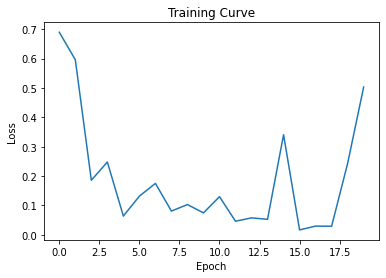

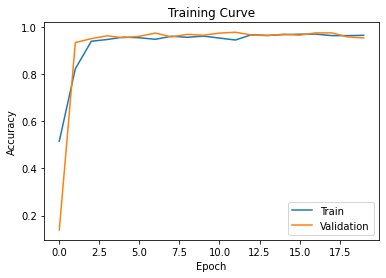

Final Training Accuracy: 0.9635477910297329
Final Validation Accuracy: 0.9524663677130045


In [14]:
model = SpamRNN(input_size, 100, 2)
train_loader = torchtext.legacy.data.BucketIterator(train_set,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)     
val_loader = torchtext.legacy.data.BucketIterator(val_set,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)

train_that_rnn(model, train_loader, val_loader, num_epochs=20, learning_rate=2e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Hyper parameters I will tune:


*   Learning rate
*   Number of hidden layers
*   RNN output pooling/manipulation
*   Number of epochs



First set of params:


*   Learning rate: 0.0002 -> 0.002
*   Number of hidden units: Still 100
*   RNN output pooling/manipulation: `self.fc(out[:, -1, :])`
*   Number of epochs: Still 20

In the first experiment I'll increase the learning by a factor of 10 to see if it improves the accuracy.

Epoch 1; Loss 0.226064; Train Acc 0.865390; Val Acc 0.858296
Epoch 2; Loss 0.459244; Train Acc 0.865390; Val Acc 0.858296
Epoch 3; Loss 0.307543; Train Acc 0.865390; Val Acc 0.858296
Epoch 4; Loss 0.119759; Train Acc 0.865390; Val Acc 0.858296
Epoch 5; Loss 0.866701; Train Acc 0.910859; Val Acc 0.880717
Epoch 6; Loss 0.681179; Train Acc 0.572839; Val Acc 0.548879
Epoch 7; Loss 0.632828; Train Acc 0.865390; Val Acc 0.858296
Epoch 8; Loss 0.904023; Train Acc 0.865390; Val Acc 0.858296
Epoch 9; Loss 0.790713; Train Acc 0.865390; Val Acc 0.858296
Epoch 10; Loss 0.050748; Train Acc 0.865390; Val Acc 0.858296
Epoch 11; Loss 0.388631; Train Acc 0.865390; Val Acc 0.858296
Epoch 12; Loss 0.143775; Train Acc 0.865390; Val Acc 0.858296
Epoch 13; Loss 0.231358; Train Acc 0.865390; Val Acc 0.858296
Epoch 14; Loss 0.174445; Train Acc 0.865390; Val Acc 0.858296
Epoch 15; Loss 0.226729; Train Acc 0.874364; Val Acc 0.859193
Epoch 16; Loss 0.190351; Train Acc 0.865390; Val Acc 0.858296
Epoch 17; Loss 0.

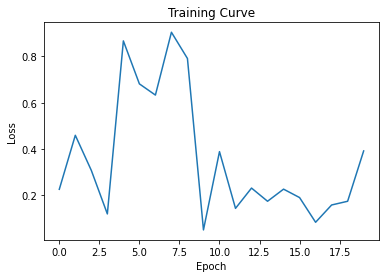

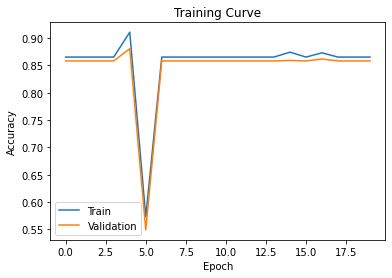

Final Training Accuracy: 0.8653903679329943
Final Validation Accuracy: 0.8582959641255605


In [96]:
model = SpamRNN(input_size, 100, 2)

train_that_rnn(model, train_loader, val_loader, num_epochs=20, learning_rate=2e-3)

Second set of params:


*   Learning rate: 0.0002
*   Number of hidden units: 100 -> 200
*   RNN output pooling/manipulation: `self.fc(out[:, -1, :])`
*   Number of epochs: Still 20

Since the validation accuracy was higher with the smaller learning rate, I'll go back to that learning rate and this time increase the number of hidden units from 100 to 200

Epoch 1; Loss 0.258765; Train Acc 0.865390; Val Acc 0.858296
Epoch 2; Loss 0.261844; Train Acc 0.865390; Val Acc 0.858296
Epoch 3; Loss 1.021623; Train Acc 0.865390; Val Acc 0.858296
Epoch 4; Loss 0.354661; Train Acc 0.865390; Val Acc 0.858296
Epoch 5; Loss 0.184913; Train Acc 0.887526; Val Acc 0.870852
Epoch 6; Loss 0.062403; Train Acc 0.899491; Val Acc 0.885202
Epoch 7; Loss 0.161398; Train Acc 0.885432; Val Acc 0.868161
Epoch 8; Loss 0.090667; Train Acc 0.955728; Val Acc 0.927354
Epoch 9; Loss 0.017485; Train Acc 0.947951; Val Acc 0.944395
Epoch 10; Loss 0.352198; Train Acc 0.907867; Val Acc 0.880717
Epoch 11; Loss 0.061195; Train Acc 0.936883; Val Acc 0.912108
Epoch 12; Loss 0.110423; Train Acc 0.965899; Val Acc 0.942601
Epoch 13; Loss 0.023763; Train Acc 0.945558; Val Acc 0.927354
Epoch 14; Loss 0.062125; Train Acc 0.962309; Val Acc 0.957848
Epoch 15; Loss 0.046804; Train Acc 0.958121; Val Acc 0.956054
Epoch 16; Loss 0.277785; Train Acc 0.924918; Val Acc 0.899552
Epoch 17; Loss 0.

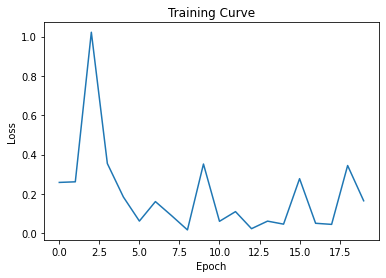

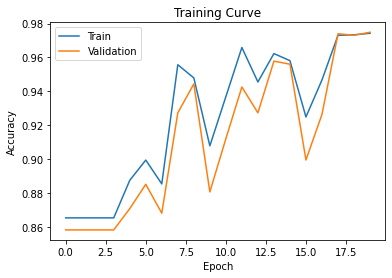

Final Training Accuracy: 0.9742746036494166
Final Validation Accuracy: 0.9748878923766816


In [97]:
model = SpamRNN(input_size, 200, 2)

train_that_rnn(model, train_loader, val_loader, num_epochs=20, learning_rate=2e-4)

Third set of params:


*   Learning rate: 0.0002
*   Number of hidden layers: 200
*   RNN output pooling/manipulation: `self.fc(torch.max(out, dim=1)[0])`
*   Number of epochs: Still 20

Since more hidden units improved the validation accuracy by a lot, I will keep the 200 layers and change the output layer to max pool this time.

Epoch 1; Loss 0.634815; Train Acc 0.952629; Val Acc 0.931839
Epoch 2; Loss 0.188773; Train Acc 0.939358; Val Acc 0.957848
Epoch 3; Loss 0.428881; Train Acc 0.947421; Val Acc 0.965022
Epoch 4; Loss 0.086104; Train Acc 0.941038; Val Acc 0.973991
Epoch 5; Loss 0.263960; Train Acc 0.953469; Val Acc 0.958744
Epoch 6; Loss 0.340332; Train Acc 0.943390; Val Acc 0.976682
Epoch 7; Loss 0.034115; Train Acc 0.953637; Val Acc 0.974888
Epoch 8; Loss 0.115938; Train Acc 0.952965; Val Acc 0.975785
Epoch 9; Loss 0.179088; Train Acc 0.966236; Val Acc 0.969507
Epoch 10; Loss 0.039500; Train Acc 0.957668; Val Acc 0.949776
Epoch 11; Loss 0.053044; Train Acc 0.951453; Val Acc 0.980269
Epoch 12; Loss 0.055151; Train Acc 0.969427; Val Acc 0.969507
Epoch 13; Loss 0.067246; Train Acc 0.970099; Val Acc 0.973094
Epoch 14; Loss 0.013112; Train Acc 0.944398; Val Acc 0.979372
Epoch 15; Loss 0.009434; Train Acc 0.974467; Val Acc 0.971300
Epoch 16; Loss 0.031036; Train Acc 0.974467; Val Acc 0.978475
Epoch 17; Loss 0.

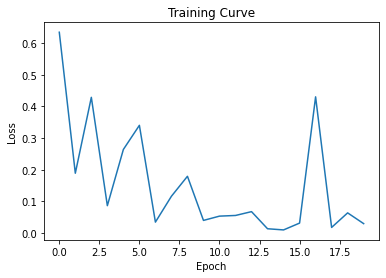

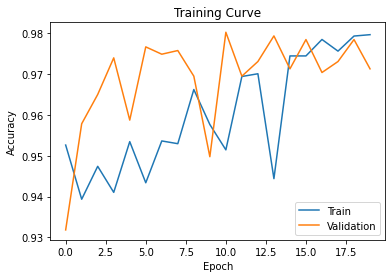

Final Training Accuracy: 0.9796741138921552
Final Validation Accuracy: 0.9713004484304932


In [15]:
model = SpamRNN(input_size, 200, 2)

train_that_rnn(model, train_loader, val_loader, num_epochs=20, learning_rate=2e-4)

Fourth set of params:


*   Learning rate: 0.0002
*   Number of hidden layers: Still 100
*   RNN output pooling/manipulation: `self.fc(out[:, -1, :])`
*   Number of epochs: Still 20

The validation accuracy was improved by using max pooling on the output, so we will keep that change. Lastly I'll increase the number of epochs to 30 to see if the validation accuracy improves with more time.

Epoch 1; Loss 0.185110; Train Acc 0.865390; Val Acc 0.858296
Epoch 2; Loss 1.335810; Train Acc 0.865390; Val Acc 0.858296
Epoch 3; Loss 0.310020; Train Acc 0.865390; Val Acc 0.858296
Epoch 4; Loss 0.268998; Train Acc 0.865390; Val Acc 0.858296
Epoch 5; Loss 0.221329; Train Acc 0.865390; Val Acc 0.858296
Epoch 6; Loss 0.114427; Train Acc 0.865390; Val Acc 0.858296
Epoch 7; Loss 0.156192; Train Acc 0.865390; Val Acc 0.858296
Epoch 8; Loss 0.215658; Train Acc 0.865390; Val Acc 0.858296
Epoch 9; Loss 0.604830; Train Acc 0.865390; Val Acc 0.858296
Epoch 10; Loss 0.109276; Train Acc 0.977565; Val Acc 0.980269
Epoch 11; Loss 0.058647; Train Acc 0.975172; Val Acc 0.975785
Epoch 12; Loss 0.065406; Train Acc 0.972779; Val Acc 0.976682
Epoch 13; Loss 0.062808; Train Acc 0.974574; Val Acc 0.974888
Epoch 14; Loss 0.385553; Train Acc 0.978462; Val Acc 0.976682
Epoch 15; Loss 0.028765; Train Acc 0.979360; Val Acc 0.977578
Epoch 16; Loss 0.142975; Train Acc 0.979659; Val Acc 0.979372
Epoch 17; Loss 0.

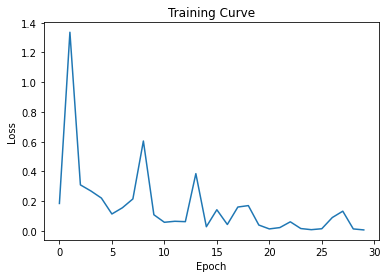

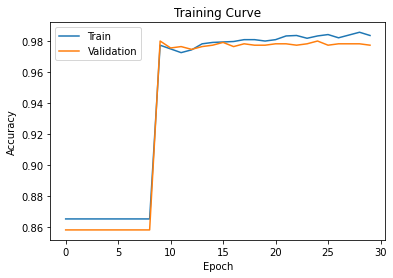

Final Training Accuracy: 0.9838468441519593
Final Validation Accuracy: 0.9775784753363229


In [100]:
model = SpamRNN(input_size, 200, 2)

train_that_rnn(model, train_loader, val_loader, num_epochs=30, learning_rate=2e-4)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [16]:
# Create a Dataset of only spam validation examples
val_spam = torchtext.legacy.data.Dataset(
    [e for e in val_set.examples if e.label == 1],
    val_set.fields)
# Create a Dataset of only non-spam validation examples
val_nospam = torchtext.legacy.data.Dataset(
    [e for e in val_set.examples if e.label == 0],
    val_set.fields)

val_spam_iter = torchtext.legacy.data.BucketIterator(val_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

val_nospam_iter = torchtext.legacy.data.BucketIterator(val_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

torch.save(model.state_dict(), "/content/last_model")
last_model = SpamRNN(input_size, 200, 2)
state = torch.load("last_model")
last_model.load_state_dict(state)

fp_rate = 1 - get_accuracy(last_model, val_nospam_iter)
fn_rate = 1 - get_accuracy(last_model, val_spam_iter)

print("False positive rate is:", fp_rate)
print("False negative rate is:", fn_rate)

False positive rate is: 0.02169421487603307
False negative rate is: 0.07482993197278909


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

So a false positive would be if a text that is not spam, is flagged as spam. If this happens, the user might miss an important message because it's gone into its spam folder by mistake.

False negative would be if a spam is falsly detected as non-spam, and the user would get that message in their main inbox. A user can open a spam email thining that it's a true message and suffer the consequences.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [101]:
test_loader = torchtext.legacy.data.BucketIterator(test_set,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)
get_accuracy(model, test_loader)

0.973967684021544

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [17]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test_set.examples if e.label == 1],
    test_set.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test_set.examples if e.label == 0],
    test_set.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

fp_rate = 1 - get_accuracy(last_model, test_nospam_iter)
fn_rate = 1 - get_accuracy(last_model, test_spam_iter)

print("False positive rate is:", fp_rate)
print("False negative rate is:", fn_rate)

False positive rate is: 0.0273972602739726
False negative rate is: 0.042424242424242475


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [23]:
from os import pread
from pyparsing.helpers import CharsNotIn
msg = "machine learning is sooo cool!"
chars = []
for char in msg:
  chars.append(text_field.vocab.stoi[char])

chars = torch.tensor(chars)
chars = chars.reshape(1, len(chars))

out = model(chars)
pred = torch.softmax(out, dim = 1)[0][1].item()

print("SPAM, with probabiity:", pred)

SPAM, with probabiity: 0.0228823721408844


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think detecting spam message could be very difficult especially since the hacker tries to do a good job masking their spam message and use familiar vocabulary.

Since we're classifiying messages as spam or not spam, this is a binary classification problem. So we can use regression and specifically logistic regression since it's classification. We would use the sigmoid activation function and map values to either 0 or 1. Thus 0 could mean not-spam, and 1 could mean spam. 

In [71]:
%%shell
jupyter nbconvert --to html /content/Lab5_Spam_Detection.ipynb

[NbConvertApp] Converting notebook /content/Lab5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 587854 bytes to /content/Lab5_Spam_Detection.html
